In [0]:
!wget http://efd1b2e3.ngrok.io/dataset.zip

In [0]:
!unzip dataset.zip

In [0]:
ls

dataset/  dataset.zip  sample_data/


In [0]:
!mkdir VGG19

In [0]:
!mkdir VGG19/logs

In [0]:
!mkdir VGG19/models

In [0]:
!touch VGG19/logs/output.log

In [0]:
import numpy as np
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt

import keras

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input
from keras.utils import to_categorical
from keras.optimizers import SGD, RMSprop, adadelta, Adam

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, CSVLogger

Using TensorFlow backend.


In [0]:
img_rows = 128
img_cols = 128
num_channels = 3
epochs = 50
num_classes = 3
NAME = "vgg19_custom_epoch_" + str(epochs)

In [0]:
from keras.applications import vgg19

In [0]:
input_layer = Input(shape=(img_rows, img_cols, num_channels))

In [0]:
vgg_model = vgg19.VGG19(include_top=False, weights='imagenet', input_tensor=input_layer)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [0]:
for i in range(2):
  vgg_model.layers.pop()

In [0]:
for layer in vgg_model.layers:
  layer.trainable = False

In [0]:
last_layer = vgg_model.get_layer('block5_conv3').output

In [0]:
conv_1 = Conv2D(64, (3, 3), strides=(1, 1), activation='relu')(last_layer)
conv_2 = Conv2D(64, (3, 3), strides=(1, 1), activation='relu')(conv_1)
conv_3 = Conv2D(32, (3, 3), strides=(1, 1), activation='relu')(conv_2)

flatten = Flatten()(conv_3)

dense_1 = Dense(512, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(dense_1)

output = Dense(num_classes, activation='softmax', name='output')(dense_2)

custom_vgg_model = Model(input_layer, output)
custom_vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [0]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        shear_range=0.4,
        zoom_range=0.5,
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        # randomly rotate images in the range (degrees, 0 to 180)
        rotation_range=180,
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.4,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.4,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

test_datagen = ImageDataGenerator(
        rescale=1./255,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        shear_range=0.4,
        zoom_range=0.5,
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        # randomly rotate images in the range (degrees, 0 to 180)
        rotation_range=180,
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.4,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.4,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

train_generator = train_datagen.flow_from_directory(
        'dataset/train',
        target_size=(img_rows, img_cols),
        color_mode="rgb",
        batch_size=32,
        class_mode="categorical",
        shuffle=True,)

test_generator = test_datagen.flow_from_directory(
        'dataset/test',
        target_size=(img_rows, img_cols),
        color_mode="rgb",
        batch_size=32,
        class_mode="categorical",
        shuffle=True,)

Found 4496 images belonging to 3 classes.
Found 1342 images belonging to 3 classes.


In [0]:
tensorboard = TensorBoard(log_dir = 'VGG19/logs/' + NAME)

In [0]:
csv_logger = CSVLogger('VGG19/logs/output.log')

In [0]:
augmented_checkpoint = ModelCheckpoint('VGG19/models/augmented_best_model.hdf5',  # model filename
                                       monitor='val_loss',  # quantity to monitor
                                       verbose=1,  # verbosity - 0 or 1
                                       save_best_only=True,  # The latest best model will not be overwritten
                                       mode='auto')  # The decision to overwrite model is made automatically depending on the quantity to monitor

In [0]:
custom_vgg_model.compile(loss=keras.losses.categorical_crossentropy,  # Better loss function for neural networks
              optimizer=Adam(),  # Adam optimizer
              metrics=['accuracy'])  # Metrics to be evaluated by the model

In [0]:
history = custom_vgg_model.fit_generator(generator=train_generator,
                    validation_data=test_generator,
                    epochs=epochs,
                    callbacks=[augmented_checkpoint, tensorboard, csv_logger],
                    verbose=1,
                    steps_per_epoch=1024,
                    validation_steps=64,
)

In [18]:
# serialize model to JSON
model_json = custom_vgg_model.to_json()
with open("VGG19/models/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
custom_vgg_model.save_weights("VGG19/models/model.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
%matplotlib inline

import glob
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import imageio as im
from keras import models
from keras.preprocessing import image

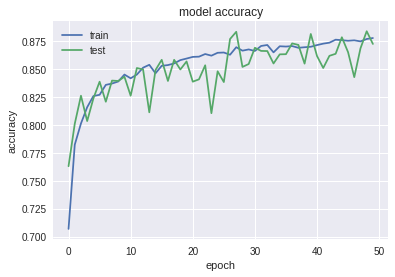

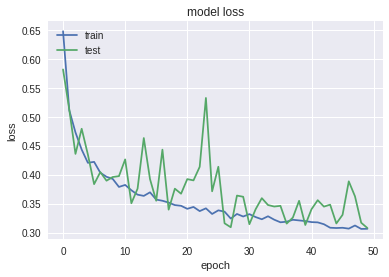

In [20]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

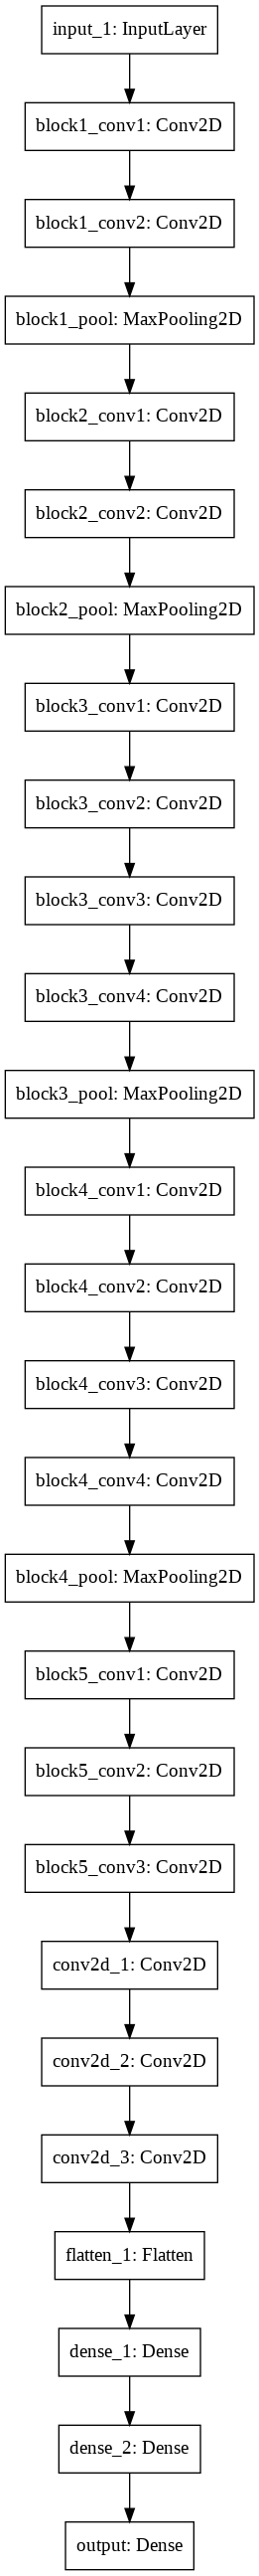

In [21]:
from keras.utils import plot_model
from PIL import Image

plot_model(custom_vgg_model, to_file='VGG19/models/plot_model.png')
Image.open('VGG19/models/plot_model.png')

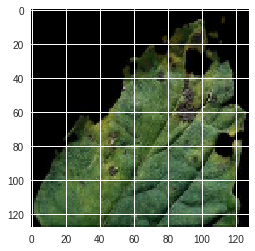

In [27]:
img_path = 'dataset/train/Early_blight/0012b9d2-2130-4a06-a834-b1f3af34f57e___RS_Erly.B 8389_final_masked.jpg'

img = image.load_img(img_path, target_size=(img_rows, img_cols))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.show()

In [0]:
layer_outputs = [layer.output for layer in custom_vgg_model.layers[1:-4]] # Extracts the outputs of all layers
activation_model = models.Model(inputs=custom_vgg_model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [0]:
activations = activation_model.predict(img_tensor) # Returns a list of five Numpy arrays: one array per layer activation

In [30]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 128, 128, 64)


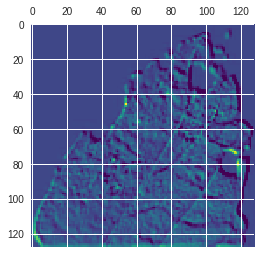

In [31]:
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

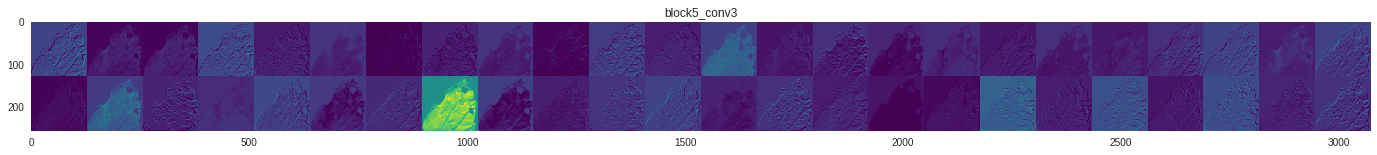

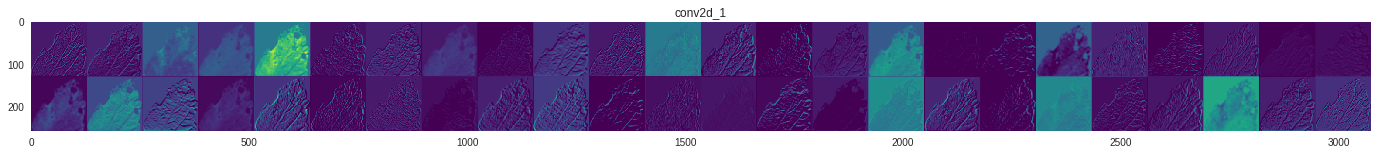

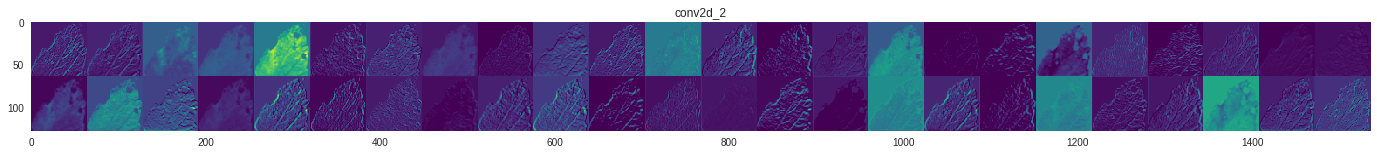

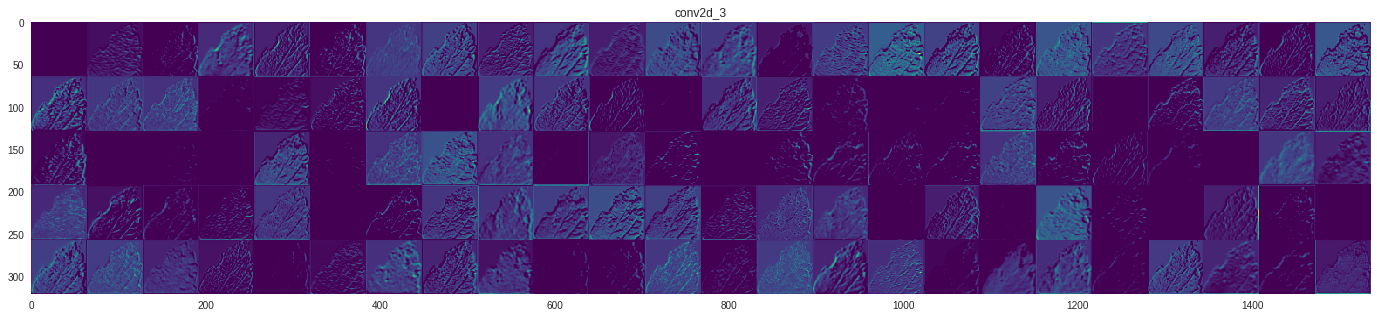

In [32]:
layer_names = []
for layer in custom_vgg_model.layers[-8:-4]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 24

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            #channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            #channel_image /= channel_image.std()
            #channel_image *= 64
            #channel_image += 128
            #channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [3]:
from keras.models import load_model
import cv2
import numpy as np
from keras.models import model_from_json
from keras.preprocessing.image import img_to_array
import argparse
import imutils
import pickle
import os
import matplotlib.pyplot as plt

In [4]:
json_file = open('models/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("models/model.h5")
classes = ['Early Blight', 'Healthy', 'Late Blight']

[INFO] class followed by probability...


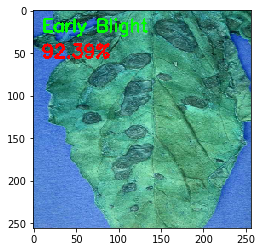

In [43]:
image_path = "alternariasol1.jpg"

img = cv2.imread(image_path)
output = cv2.resize(img, (256, 256)).copy()
img = cv2.resize(img, (128, 128))
img = img / 255

proba = model.predict(img.reshape(-1, 128, 128, 3))

idx = np.argmax(proba)
label = classes[idx]
cv2.putText(output, label, (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,
	0.7, (0, 255, 0), 2)
cv2.putText(output, str(np.max(proba) * 100)[:5] + "%", (10, 55),  cv2.FONT_HERSHEY_SIMPLEX,
	0.7, (255, 0, 0), 2)


# show the output image
print("[INFO] class followed by probability...")
plt.imshow(output)

# Confusion Matrix and Report of the Model

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import model_from_json

%matplotlib inline

Using TensorFlow backend.


In [2]:
label_dictionary = {0: 'Early Blight', 1: 'Healthy', 2: 'Late Blight'}

json_file = open('models/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("models/model.h5")

In [3]:
img_rows = 128
img_cols = 128
num_channels = 3
epochs = 50
num_classes = 3

In [4]:
test_datagen = ImageDataGenerator(
        rescale=1./255,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        shear_range=0.4,
        zoom_range=0.5,
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        # randomly rotate images in the range (degrees, 0 to 180)
        rotation_range=180,
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.4,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.4,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

test_generator = test_datagen.flow_from_directory(
        '../../../../dataset/dataset/test/',
        target_size=(img_rows, img_cols),
        color_mode="rgb",
        batch_size=32,
        class_mode="categorical",
        shuffle=False,)

Found 1342 images belonging to 3 classes.


In [7]:
Y_pred = model.predict_generator(test_generator, test_generator.samples // test_generator.batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)
# print('******************Confusion Matrix******************')
c_mat = confusion_matrix(test_generator.classes, y_pred)
print('******************Classification Report******************')
target_names = ['Early Blight','Healthy','Late Blight']
cls_report = classification_report(test_generator.classes, y_pred, target_names=target_names)
print(cls_report)

******************Classification Report******************
              precision    recall  f1-score   support

Early Blight       0.88      0.95      0.91       500
     Healthy       0.88      0.88      0.88       342
 Late Blight       0.89      0.80      0.84       500

   micro avg       0.88      0.88      0.88      1342
   macro avg       0.88      0.88      0.88      1342
weighted avg       0.88      0.88      0.88      1342



In [8]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

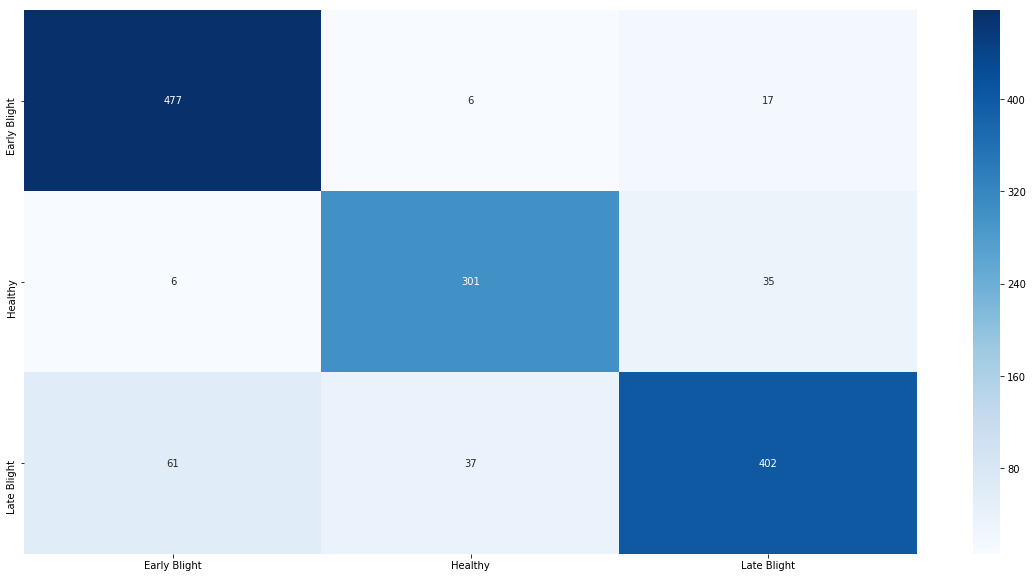

In [9]:
df_cm = pd.DataFrame(c_mat, index = [i for i in target_names],
                  columns = [i for i in target_names])
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

# Confusion Matrix and Classification Report of Real World Data

In [10]:
real_world_data = test_datagen.flow_from_directory(
        '../../../../dataset/validation/',
        target_size=(img_rows, img_cols),
        color_mode="rgb",
        batch_size=32,
        class_mode="categorical",
        shuffle=False,)

Found 325 images belonging to 3 classes.


In [11]:
Y_pred = model.predict_generator(real_world_data, real_world_data.samples // real_world_data.batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)
# print('******************Confusion Matrix******************')
c_mat = confusion_matrix(real_world_data.classes, y_pred)
print('******************Classification Report******************')
target_names = ['Early Blight','Healthy','Late Blight']
cls_report = classification_report(real_world_data.classes, y_pred, target_names=target_names)
print(cls_report)

******************Classification Report******************
              precision    recall  f1-score   support

Early Blight       0.39      0.18      0.25       153
     Healthy       0.49      0.41      0.45        56
 Late Blight       0.33      0.59      0.43       116

   micro avg       0.37      0.37      0.37       325
   macro avg       0.40      0.40      0.37       325
weighted avg       0.39      0.37      0.35       325



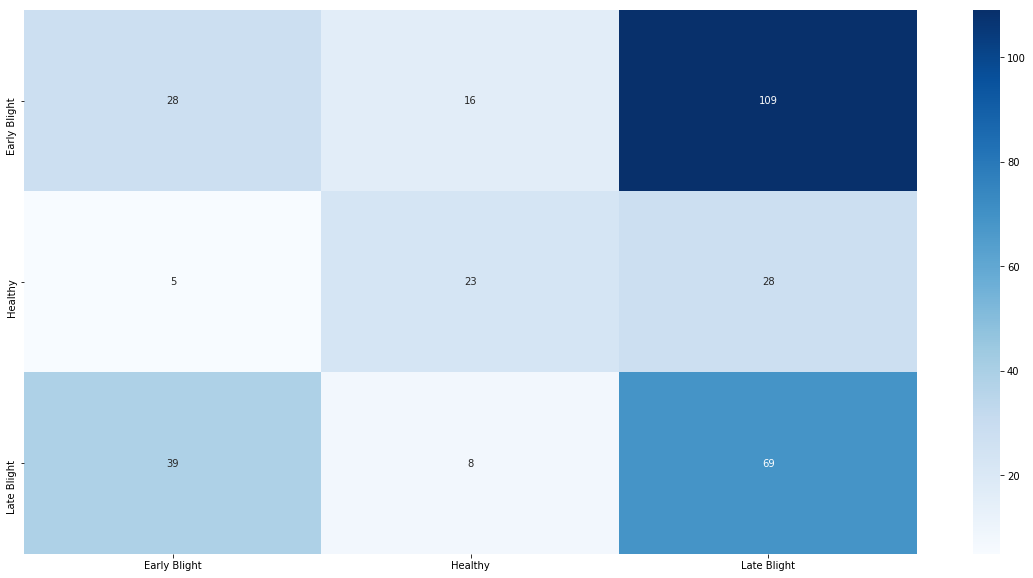

In [12]:
df_cm = pd.DataFrame(c_mat, index = [i for i in target_names],
                  columns = [i for i in target_names])
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')